In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
#                                             torchvision.transforms.Normalize(mean=(0.5071, 0.4865, 0.4409), 
#                                             std=(0.2648, 0.2542, 0.2733))])

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
#                                             torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

cifar_dset_train = torchvision.datasets.CIFAR100('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR100('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# activation = hard_sigmoid
# # architecture = [int(32*32*3), 500, 10]
# architecture = [int(32*32*3), 2500, 500, 100]

# x,y = next(iter(train_loader))
# x = x.view(x.size(0),-1).to(device).T
# y_one_hot = F.one_hot(y, 100).to(device).T

# beta = 0.2
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.4, 0.25, 0.2]), 'fb': np.array([np.nan, 0.22, 0.11])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.1
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False


# activation = hard_sigmoid
# # architecture = [int(32*32*3), 500, 10]
# architecture = [int(32*32*3), 2000,  100]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.1, 0.08]), 'fb': np.array([np.nan, 0.02])}

# neural_lr_start = 0.05
# neural_lr_stop = 0.001
# neural_lr_rule = "divide_by_slow_loop_index"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 50
# hopfield_g = 0.1
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False

activation = hard_sigmoid
# architecture = [int(32*32*3), 500, 10]
architecture = [int(32*32*3), 2000, 1000, 100]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start =  {'ff' : np.array([0.15, 0.06, 0.04]), 'fb': np.array([np.nan, 0.03, 0.01])}

neural_lr_start = 0.03
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 20
neural_dynamic_iterations_free = 50
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
# _ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
#                                           neural_lr_start, neural_lr_stop, neural_lr_rule, 
#                                           neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

In [ ]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 50
lr = lr_start
for epoch_ in range(n_epochs):
#     if epoch_ < 15:
#         lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
#     else:
#         lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 100).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield_topk( model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, topk = (1,5), printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield_topk( model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, topk = (1, 5), printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, (top {}) Train Accuracy : {}, Test Accuracy : {}".format( epoch_+1,(1,5), trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

2500it [05:37,  7.42it/s]
0it [00:00, ?it/s]

Epoch : 1, (top (1, 5)) Train Accuracy : [0.02524 0.08296], Test Accuracy : [0.0253 0.084 ]
Free Information ratio: [0.49796166 0.02675843]
Nudged Information ratio: [0.49796176 0.02675841]


2500it [05:47,  7.20it/s]
0it [00:00, ?it/s]

Epoch : 2, (top (1, 5)) Train Accuracy : [0.03404 0.10196], Test Accuracy : [0.0327 0.1018]
Free Information ratio: [0.48473622 0.03366042]
Nudged Information ratio: [0.48473631 0.03366039]


2500it [05:48,  7.16it/s]
0it [00:00, ?it/s]

Epoch : 3, (top (1, 5)) Train Accuracy : [0.04678 0.128  ], Test Accuracy : [0.0468 0.1252]
Free Information ratio: [0.48870305 0.04271347]
Nudged Information ratio: [0.48870312 0.04271343]


2500it [05:32,  7.51it/s]
0it [00:00, ?it/s]

Epoch : 4, (top (1, 5)) Train Accuracy : [0.05974 0.1485 ], Test Accuracy : [0.0583 0.1449]
Free Information ratio: [0.49940287 0.04530822]
Nudged Information ratio: [0.49940287 0.04530816]


2500it [05:37,  7.41it/s]
0it [00:00, ?it/s]

Epoch : 5, (top (1, 5)) Train Accuracy : [0.0658 0.1616], Test Accuracy : [0.0639 0.1567]
Free Information ratio: [0.51333262 0.04955942]
Nudged Information ratio: [0.51333262 0.04955932]


2500it [05:39,  7.36it/s]
0it [00:00, ?it/s]

Epoch : 6, (top (1, 5)) Train Accuracy : [0.07644 0.17924], Test Accuracy : [0.0737 0.1721]
Free Information ratio: [0.5670909  0.05708441]
Nudged Information ratio: [0.56709079 0.05708427]


2500it [05:47,  7.19it/s]
0it [00:00, ?it/s]

Epoch : 7, (top (1, 5)) Train Accuracy : [0.08312 0.19048], Test Accuracy : [0.0809 0.1805]
Free Information ratio: [0.56831331 0.05864656]
Nudged Information ratio: [0.5683131  0.05864639]


2500it [05:46,  7.22it/s]
0it [00:00, ?it/s]

Epoch : 8, (top (1, 5)) Train Accuracy : [0.09212 0.20826], Test Accuracy : [0.0886 0.1983]
Free Information ratio: [0.58917683 0.06263828]
Nudged Information ratio: [0.58917664 0.06263809]


2500it [05:46,  7.22it/s]
0it [00:00, ?it/s]

Epoch : 9, (top (1, 5)) Train Accuracy : [0.09894 0.21642], Test Accuracy : [0.0959 0.2069]
Free Information ratio: [0.57001825 0.06103558]
Nudged Information ratio: [0.57001792 0.06103528]


2500it [04:18,  9.68it/s]
0it [00:00, ?it/s]

Epoch : 10, (top (1, 5)) Train Accuracy : [0.1051 0.2245], Test Accuracy : [0.0987 0.2132]
Free Information ratio: [0.63941482 0.069317  ]
Nudged Information ratio: [0.6394145  0.06931674]


2500it [04:18,  9.68it/s]
0it [00:00, ?it/s]

Epoch : 11, (top (1, 5)) Train Accuracy : [0.11422 0.24094], Test Accuracy : [0.1077 0.2279]
Free Information ratio: [0.64896991 0.07395726]
Nudged Information ratio: [0.64896942 0.07395688]


2500it [04:18,  9.68it/s]
0it [00:00, ?it/s]

Epoch : 12, (top (1, 5)) Train Accuracy : [0.1193  0.24258], Test Accuracy : [0.1091 0.2239]
Free Information ratio: [0.68762261 0.07876274]
Nudged Information ratio: [0.68762218 0.07876237]


2500it [04:18,  9.68it/s]
0it [00:00, ?it/s]

Epoch : 13, (top (1, 5)) Train Accuracy : [0.12604 0.26412], Test Accuracy : [0.1154 0.2481]
Free Information ratio: [0.67142284 0.07753382]
Nudged Information ratio: [0.67142225 0.07753332]


2500it [04:18,  9.68it/s]
0it [00:00, ?it/s]

Epoch : 14, (top (1, 5)) Train Accuracy : [0.133   0.26342], Test Accuracy : [0.1211 0.2467]
Free Information ratio: [0.67304737 0.07919632]
Nudged Information ratio: [0.67304684 0.07919585]


2500it [04:17,  9.70it/s]
0it [00:00, ?it/s]

Epoch : 15, (top (1, 5)) Train Accuracy : [0.13782 0.27286], Test Accuracy : [0.1217 0.257 ]
Free Information ratio: [0.70994914 0.08772745]
Nudged Information ratio: [0.70994851 0.08772687]


2500it [04:17,  9.72it/s]
0it [00:00, ?it/s]

Epoch : 16, (top (1, 5)) Train Accuracy : [0.14472 0.27124], Test Accuracy : [0.1297 0.2481]
Free Information ratio: [0.67793443 0.08584822]
Nudged Information ratio: [0.67793374 0.08584755]


2500it [04:17,  9.70it/s]
0it [00:00, ?it/s]

Epoch : 17, (top (1, 5)) Train Accuracy : [0.15044 0.2835 ], Test Accuracy : [0.1286 0.2634]
Free Information ratio: [0.73598846 0.09352933]
Nudged Information ratio: [0.73598778 0.09352867]


1555it [02:42,  9.82it/s]

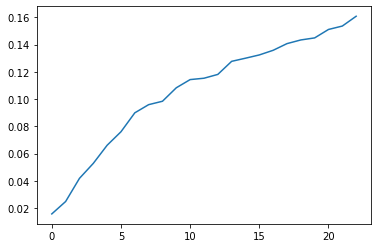

In [12]:
plt.plot(np.array(tst_acc_list)[:,0])

In [ ]:
# for epoch_ in range(n_epochs, n_epochs + 25):
#     lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
#     for idx, (x, y) in tqdm(enumerate(train_loader)):
#         x, y = x.to(device), y.to(device)
#         x = x.view(x.size(0),-1).T
#         y_one_hot = F.one_hot(y, 10).to(device).T
#         take_debug_logs_ = (idx % 500 == 0)
#         if use_random_sign_beta:
#             rnd_sgn = 2*np.random.randint(2) - 1
#             beta = rnd_sgn*beta
            
#         neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
#                                              lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
#                                              neural_lr_decay_multiplier, neural_dynamic_iterations_free,
#                                              neural_dynamic_iterations_nudged, beta, 
#                                              use_three_phase, take_debug_logs_, weight_decay)
    
#     trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
#                                                     neural_lr_stop, neural_lr_rule, 
#                                                     neural_lr_decay_multiplier, 
#                                                     neural_dynamic_iterations_free, 
#                                                     device, printing = False)
#     tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
#                                                     neural_lr_stop, neural_lr_rule, 
#                                                     neural_lr_decay_multiplier, 
#                                                     neural_dynamic_iterations_free, 
#                                                     device, printing = False)
#     trn_acc_list.append(trn_acc)
#     tst_acc_list.append(tst_acc)
    
#     print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
#     print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
#     print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

In [ ]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
plt.plot(model.forward_backward_angles)

In [ ]:
plt.plot((model.neural_dynamics_free_backward_info_list[10]))

In [ ]:
x.shape

In [ ]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [ ]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])